In [148]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
from data.neural_field_datasets_shapenet import FlattenTransform3D, ShapeNetDataset, AllWeights3D
from vector_quantize_pytorch import ResidualVQ, kmeans

# load dataset
dataset = ShapeNetDataset("./datasets/plane_mlp_weights")

In [150]:
from collections import OrderedDict
from os import listdir
from os.path import isfile, join

import torch

from utils import get_default_device


def get_weight_vector(state_dict: OrderedDict, layer: int, neuron: int) -> torch.Tensor:
    return state_dict[f"layers.{layer}.weight"][:, neuron]

def get_bias(state_dict: OrderedDict, layer: int, neuron: int) -> torch.Tensor:
    return  state_dict[f"layers.{layer}.bias"][neuron]

def get_all_weights(dataset: ShapeNetDataset, layer: int, neuron: int) -> torch.Tensor:
    all_weights = torch.stack([get_weight_vector(mlp3d[0], layer, neuron) for mlp3d in dataset])
    return all_weights



def get_all_biases(dataset: ShapeNetDataset, layer: int, neuron: int) -> torch.Tensor:
    all_biases = torch.stack([get_bias(mlp3d[0], layer, neuron) for mlp3d in dataset])
    return all_biases



In [151]:
dataset = ShapeNetDataset("./datasets/plane_mlp_weights", transform=AllWeights3D())

In [180]:
path ="./models/rq_search_results/learnable_rq_model_dim_128_vocab_287_batch_size_1024_threshold_ema_dead_code_0_kmean_iters_0_num_quantizers_2_use_init_True.pth"
dataset = ShapeNetDataset("./datasets/plane_mlp_weights", transform=AllWeights3D())

rq_dicts = torch.load(path)


In [181]:
rvq = ResidualVQ(**rq_dicts["rq_config"])
rvq.load_state_dict(rq_dicts["state_dict"])

<All keys matched successfully>

In [182]:
rq_dicts["rq_config"]

{'dim': 128,
 'codebook_size': 287,
 'decay': 0.8,
 'commitment_weight': 1.0,
 'kmeans_init': False,
 'kmeans_iters': 0,
 'threshold_ema_dead_code': 0,
 'num_quantizers': 2,
 'ema_update': False,
 'learnable_codebook': True,
 'in_place_codebook_optimizer': torch.optim.adam.Adam,
 'use_cosine_sim': True}

In [201]:
for layer in rvq.layers:
    layer.eval()
    layer.training = True

In [202]:
dataset[0][0].shape

torch.Size([287, 128])

In [222]:
rvq.layers[0]

VectorQuantize(
  (project_in): Identity()
  (project_out): Identity()
  (_codebook): CosineSimCodebook()
)

In [223]:
quantized_0, indices_0, loss_0 = rvq.layers[0](dataset[0][0])

In [ ]:
quantized_0

In [224]:
quantized_1, indices_1, loss_1 = rvq.layers[1](dataset[0][0] - quantized_0)

In [228]:
dataset_norm = dataset[0][0].norm(p=2, dim=-1, keepdim=True)
quantized_1_norm = (dataset[0][0] - quantized_0).norm(p=2, dim=-1, keepdim=True)

In [229]:
quantized_0*dataset_norm + quantized_1*quantized_1_norm

tensor([[-0.7154,  1.1090,  0.0950,  ...,  0.0263, -0.3183,  0.3249],
        [-0.6302,  6.9132,  0.1760,  ..., -0.2754, -0.4918,  0.2230],
        [-0.1570, -0.8731, -0.0985,  ..., -0.0961, -0.0925,  0.0629],
        ...,
        [-0.1746, -0.1891, -0.0435,  ..., -0.0854, -0.1295, -0.0722],
        [-0.3456, -0.4081, -0.0896,  ..., -0.1784, -0.2610, -0.1592],
        [-0.6637, -0.7739, -0.1818,  ..., -0.2098, -0.3669, -0.4075]])

In [230]:
dataset[0][0]

tensor([[-1.3149,  0.6769,  0.1253,  ..., -0.0045, -0.1866,  0.1910],
        [-1.9470,  4.1741,  0.2301,  ..., -0.0606, -0.2085,  0.0677],
        [-0.1827, -0.2787, -0.2146,  ..., -0.2211, -0.1881, -0.7975],
        ...,
        [-0.0288,  0.0232, -0.2488,  ..., -0.2464, -0.3122,  0.0921],
        [-0.5402, -0.8153, -0.0747,  ..., -0.4094, -1.4079, -0.1554],
        [-0.8989, -0.0449, -0.3596,  ...,  0.0108, -0.0728, -0.7832]])

In [219]:
quantized, indices, loss = rvq(dataset[0][0])

In [197]:
dataset[0][0]

tensor([[-1.3149,  0.6769,  0.1253,  ..., -0.0045, -0.1866,  0.1910],
        [-1.9470,  4.1741,  0.2301,  ..., -0.0606, -0.2085,  0.0677],
        [-0.1827, -0.2787, -0.2146,  ..., -0.2211, -0.1881, -0.7975],
        ...,
        [-0.0288,  0.0232, -0.2488,  ..., -0.2464, -0.3122,  0.0921],
        [-0.5402, -0.8153, -0.0747,  ..., -0.4094, -1.4079, -0.1554],
        [-0.8989, -0.0449, -0.3596,  ...,  0.0108, -0.0728, -0.7832]])

tensor([[1.5821],
        [1.7209],
        [1.4479],
        [1.5821],
        [1.7209],
        [1.4479],
        [5.2103],
        [5.2103],
        [5.2103],
        [1.5821],
        [1.7209],
        [1.4479],
        [5.2103],
        [5.2103],
        [5.2103],
        [1.5821],
        [1.7209],
        [2.8002],
        [1.9246],
        [5.2103],
        [1.6459],
        [1.4879],
        [1.7209],
        [1.5332],
        [2.3842],
        [5.2103],
        [1.8822],
        [3.7619],
        [1.6654],
        [1.0774],
        [5.2103],
        [0.9694],
        [1.2777],
        [6.1507],
        [5.2103],
        [5.2103],
        [2.7117],
        [2.8375],
        [2.1485],
        [1.2480],
        [5.2103],
        [1.2205],
        [1.6983],
        [1.4516],
        [1.4839],
        [0.6340],
        [5.2103],
        [2.7595],
        [1.9340],
        [1.1815],
        [2.4259],
        [5.8100],
        [3.7619],
        [5.9255],
        [0.7291],
        [3

In [210]:
quantized * quantized.norm(p=2, dim=-1, keepdim=True)

tensor([[-0.1398,  0.2578,  0.0067,  ...,  0.0022, -0.0567,  0.0539],
        [-0.0345,  0.5666,  0.0138,  ..., -0.0308, -0.0490,  0.0282],
        [-0.0262, -0.2580, -0.0314,  ..., -0.0224, -0.0267,  0.0326],
        ...,
        [-0.2423, -0.2699, -0.0769,  ..., -0.1205, -0.1915, -0.1536],
        [-0.2423, -0.2699, -0.0769,  ..., -0.1205, -0.1915, -0.1536],
        [-0.3200, -0.4053, -0.0855,  ..., -0.1178, -0.2277, -0.2164]])

In [209]:
dataset[0][0]

tensor([[-1.3149,  0.6769,  0.1253,  ..., -0.0045, -0.1866,  0.1910],
        [-1.9470,  4.1741,  0.2301,  ..., -0.0606, -0.2085,  0.0677],
        [-0.1827, -0.2787, -0.2146,  ..., -0.2211, -0.1881, -0.7975],
        ...,
        [-0.0288,  0.0232, -0.2488,  ..., -0.2464, -0.3122,  0.0921],
        [-0.5402, -0.8153, -0.0747,  ..., -0.4094, -1.4079, -0.1554],
        [-0.8989, -0.0449, -0.3596,  ...,  0.0108, -0.0728, -0.7832]])

In [165]:
(dataset[0][0] - quantized).abs().mean()

tensor(0.3370)

In [104]:
torch.cat((
    state_dict[f"layers.0.weight"].T, 
    state_dict[f"layers.1.weight"].T, 
    state_dict[f"layers.2.weight"].T, 
    state_dict[f"layers.3.weight"],
    state_dict[f"layers.0.bias"].unsqueeze(0),
    state_dict[f"layers.1.bias"].unsqueeze(0),
    state_dict[f"layers.2.bias"].unsqueeze(0),
    )).shape

torch.Size([287, 128])

In [77]:
state_dict[f"layers.1.weight"].shape

torch.Size([128, 128])

In [81]:
state_dict[f"layers.3.weight"]

torch.Size([1, 128])

In [47]:
biases = get_all_biases(dataset, 3, 0)

In [50]:
print(biases.mean())
print(biases.std())
print(biases.min())
print(biases.max())

tensor(1.0706)
tensor(0.7267)
tensor(-5.4607)
tensor(4.3834)


In [65]:
(pos_biases < 2).int().sum()

tensor(3446)

(array([ 2.,  1.,  0.,  2.,  2.,  4.,  2.,  1.,  2.,  1.,  5.,  2.,  1.,
         0.,  1.,  2.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  3.,  3.,
         3.,  0.,  1.,  0.,  3.,  0.,  1.,  4.,  3.,  0.,  2.,  1.,  1.,
         3.,  1.,  2.,  1.,  2.,  6.,  2.,  3.,  3.,  0.,  1.,  0.,  1.,
         3.,  3.,  3.,  0.,  2.,  3.,  1.,  1.,  3.,  0.,  2.,  0.,  2.,
         2.,  4.,  5.,  2.,  4.,  1.,  4.,  1.,  1.,  3.,  2.,  2.,  2.,
         1.,  2.,  0.,  2.,  2.,  1.,  1.,  2.,  1.,  6.,  3.,  1.,  4.,
         2.,  0.,  2.,  3.,  5.,  0.,  4.,  1.,  4.,  2.,  1.,  2.,  4.,
         2.,  2.,  3.,  4.,  4.,  3.,  1.,  1.,  2.,  5.,  1.,  7.,  5.,
         3.,  1.,  2.,  1.,  2.,  3.,  1.,  6.,  3.,  2.,  2.,  1.,  0.,
         2.,  3.,  4.,  5.,  3.,  1.,  1.,  6.,  2.,  3.,  1.,  2.,  3.,
         6.,  4.,  2.,  4.,  2.,  0.,  3.,  4.,  2.,  3.,  2.,  4.,  6.,
         2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  4.,  1.,  5.,  2.,  5.,
         3.,  2.,  2.,  2.,  1.,  3.,  5.,  1.,  1.

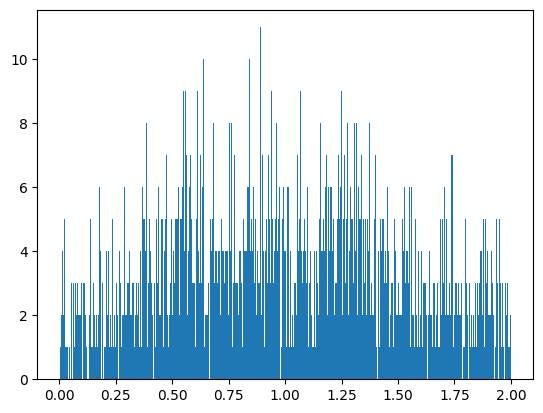

In [64]:
import matplotlib.pyplot as plt

pos_biases = biases[biases>0]

plt.hist(pos_biases[pos_biases<2], bins=1000)


In [31]:
compute_weights = True
if compute_weights:
    import h5py

    all_weights_layer_0 = torch.zeros(27, 4045, 128)
    all_weights_layer_1 = torch.zeros(128, 4045, 128)
    all_weights_layer_2 = torch.zeros(128, 4045, 128)
    all_weights_layer_3 = torch.zeros(128, 4045, 1)


    for i in range(27):
        all_weights_layer_0[i] = get_all_weights(dataset, 0, i)

    for i in range(128):
        all_weights_layer_1[i] = get_all_weights(dataset, 1, i)

    for i in range(128):
        all_weights_layer_2[i] = get_all_weights(dataset, 2, i)

    for i in range(128):
        all_weights_layer_3[i] = get_all_weights(dataset, 3, i)
        
    all_weights = torch.cat((all_weights_layer_0.view(-1, 128), all_weights_layer_1.view(-1, 128), all_weights_layer_2.view(-1, 128), all_weights_layer_3.view(-1, 128)))

    # Save the tensor to an HDF5 file
    with h5py.File('datasets/plane_mlp_weights.h5', 'w') as f:
        f.create_dataset('dataset', data=all_weights)




In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import h5py

class HDF5Dataset(Dataset):
    def __init__(self, hdf5_file, dataset_name):
        self.hdf5_file = hdf5_file
        self.dataset_name = dataset_name
        with h5py.File(self.hdf5_file, 'r') as f:
            self.dataset_length = f[self.dataset_name].shape[0]
    
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, 'r') as f:
            data = f[self.dataset_name][idx]
            return torch.tensor(data)

# Instantiate the dataset and dataloader
hdf5_dataset = HDF5Dataset('datasets/plane_mlp_weights.h5', 'dataset')

In [26]:
batch_size = 2**14
train_dataloader = DataLoader(hdf5_dataset, batch_size=batch_size, shuffle=True)

In [27]:
from networks.vq_ae import VQAutoencoderConfig
from training.training_autoencoder import train_model, TrainingConfig

from torch import nn
from torch.nn import MSELoss, CrossEntropyLoss, L1Loss
from torch.utils.data import DataLoader

import wandb

wandb.login()

batch_size = 2**14
train_dataloader = DataLoader(hdf5_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = train_dataloader#DataLoader([test_dataset[0][0][0]], batch_size=1, shuffle=True)

train_config = TrainingConfig()
train_config.max_iters = 10
train_config.always_save_checkpoint = True
train_config.weight_decay = 0.0
train_config.learning_rate = 5e-3
train_config.lr_decay_iters = train_config.max_iters*len(train_dataloader)
train_config.warmup_iters = 0.05*train_config.max_iters*len(train_dataloader)
train_config.log_interval = 1
train_config.out_dir = "models/vq_ae"

vq_config = VQAutoencoderConfig()
vq_config.dim_enc = (128, 64, 32)
vq_config.dim_dec = (32, 64, 128)
vq_config.with_vq = False


ae_trained = train_model(train_config, vq_config, train_dataloader, test_dataloader, L1Loss())

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


batch,▂▃▄▆▇▁▃▄▅▇▁▂▄▅▇█▂▄▄▆█▂▃▅▆▇▁▃▅▅▇▂▂▄▆▇█▂▄▆
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▆▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▂▄▅▆████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆
batch,52
epoch,7
loss,0.23942
lr,0.0036


Checkpoint saved: models/vq_ae/model_epoch_0.pth


Checkpoint saved: models/vq_ae/model_epoch_1.pth


Checkpoint saved: models/vq_ae/model_epoch_2.pth


Checkpoint saved: models/vq_ae/model_epoch_3.pth


Checkpoint saved: models/vq_ae/model_epoch_4.pth


KeyboardInterrupt: 

wandb: Network error (ConnectionError), entering retry loop.


In [12]:
from networks.vq_ae import VQAutoencoder


vq_ae = VQAutoencoder(vq_config)
vq_ae_dict = torch.load("models/vq_ae/model_epoch_6.pth")["model_state_dict"]
vq_ae.load_state_dict(vq_ae_dict)


for batch in train_dataloader:
    X = batch
    Y = vq_ae(X)
    error = X-Y
    break
    


In [19]:
error.abs()

tensor([[0.1078, 0.0341, 0.0054,  ..., 0.0309, 0.0983, 0.3144],
        [0.0984, 0.2903, 0.0172,  ..., 0.3958, 0.7926, 1.1895],
        [0.0341, 0.0267, 0.0785,  ..., 0.0658, 0.0469, 0.0328],
        ...,
        [0.1093, 0.0593, 0.0043,  ..., 0.0463, 0.0622, 0.0515],
        [0.3041, 0.0401, 0.0287,  ..., 0.7800, 0.6764, 3.0190],
        [0.2775, 1.1532, 0.0257,  ..., 0.7382, 0.0043, 0.2169]],
       grad_fn=<AbsBackward0>)